# <span style="color:#0b486b">  FIT3181: Deep Learning (2021)</span>
***
*CE/Lecturer:*  **Dr Trung Le** | trunglm@monash.edu <br/>
*Head TA:*  **Mr Thanh Nguyen** | thanh.nguyen4@monash.edu <br/>
*Tutor:* **Dr Van Nguyen**  \[van.nguyen1@monash.edu \] | **Mr James Tong** \[james.tong1@monash.edu\] | **Dr Mahmoud Mohammad** \[mahmoud.hossam@monash.edu\]
<br/> <br/>
Faculty of Information Technology, Monash University, Australia
***


## <span style="color:#0b486b">Tutorial 7a: Advanced Convolutional Neural Networks</span> ##

**The purpose of this tutorial is to show you how to implement ResNet, the most popular CNN model. This ResNet implementation follows the original paper of ResNet.**


**Acknowledgement:** *This tutorial is developed based on the material in chapter 7 of the book Dive Into Deep Learning*.

**References and additional reading and resources**
- Chapter 7 of Dive Into Deep Learning ([link](https://d2l.ai/chapter_convolutional-modern/index.html)).

**Hint**: The implementations of ResNet in this tutorial would facilitate you in doing Part 3 of assignment 1. 


## <span style="color:#0b486b">I. Implementation of Residual Network (ResNet)</span> <span style="color:red">****</span> ##
This is a **highly recommend-to-learn** knowledge because ResNet is the most widely popular architecture used in computer vision tasks. Moreover, we can apply what is learned here to assignment 1.  

### <span style="color:#0b486b">I.1. Residual Block</span> ###

The building block of ResNet is the **residual block** which has the following architecture: *[CONV2D, BatchNorm, RELU, CONV2D, BatchNorm]* together with the skip connection. For the skip connection, we have two options: `use 1x1 CONV1D` or `not use 1x1 CONV1D`. The following figure shows the architecture of the residual block for two options.

#### Skip connection aims to solve gradient vanishing and gradient exploding: 
https://stats.stackexchange.com/questions/339894/how-does-resnet-or-cnn-with-skip-connections-solve-the-gradient-exploding-proble

---

<img src="./imgs/ResidualBlock.png" align="center" width=600/>

In what follows, we are going to implement the class `Residual`.

In [16]:
import tensorflow as tf

we need to use 1x1 conv sometimes because sizees of X != Y 

<img src="./md_images/md1.png" align="center" width=600/>

In [17]:
class Residual(tf.keras.Model):
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        
        # conv layers
        self.conv1 = tf.keras.layers.Conv2D(num_channels, padding='same', kernel_size=3, strides=strides)
        self.conv2 = tf.keras.layers.Conv2D(num_channels, kernel_size=3, padding='same')    
        # add 1x1 conv layer or not    
        if use_1x1conv:
            self.conv3 = tf.keras.layers.Conv2D(num_channels, kernel_size=1, strides=strides)
        else:
            self.conv3 = None
        # batch normalization layers
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()

    def call(self, X):
        # 1: X -> conv -> BN -> activation -> Y
        Y = tf.keras.activations.relu(self.bn1(self.conv1(X)))
        
        # 2: Y -> conv -> BN -> Y
        Y = self.bn2(self.conv2(Y))
        
        # 3: see if X needs to do 1x1 conv ; 1x1 conv skip connection
        if self.conv3 is not None:
            X = self.conv3(X)
            
        # 3: skip connection , doing addition of matrices ; Y = Y + X
        Y += X
        
        # 4: Y -> act -> Y
        return tf.keras.activations.relu(Y)

blk = Residual(num_channels=3, use_1x1conv=True, strides=1)
X = tf.random.uniform((10, 32, 32, 3))
Y = blk(X)
print(Y.shape)

(10, 32, 32, 3)


Consider the case when we do not apply 1x1 Conv1D, hence it requires the `num_channels` is equal to the `input_depth` (equal to 3 in the following example).

In [18]:
blk = Residual(3)
X = tf.random.uniform((4, 6, 6, 3))
Y = blk(X)
Y.shape

TensorShape([4, 6, 6, 3])

If we apply 1x1 Conv1D, the output shape of the residual block can be different from the input shape.

In [19]:
blk = Residual(6, use_1x1conv=True, strides=2)
blk(X).shape

TensorShape([4, 3, 3, 6])

### <span style="color:#0b486b">I.2. ResNet Block</span> ###

We now implement **ResNet block**. A ResNet block consists of several residual blocks and we need to declare the number of residual blocks as `num_residuals` and the common number of channels of residual blocks in a ResNet block as `num_channels`.

In [20]:
class ResnetBlock(tf.keras.layers.Layer):
    def __init__(self, num_channels, num_residuals, first_block=False, **kwargs):
        super(ResnetBlock, self).__init__(**kwargs)
        self.residual_layers = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                self.residual_layers.append(
                    Residual(num_channels, use_1x1conv=True, strides=2))
            else:
                self.residual_layers.append(Residual(num_channels))

    def call(self, X):
        for layer in self.residual_layers.layers:  # tf.keras.Model.layers
            X = layer(X)
        return X

Note that from the second ResNet block, we apply `1x1 Conv1D` over the skip connection of every first residual block.

### <span style="color:#0b486b">I.3. Residual Network</span> ###

We now declare our ResNet. Note that we set `input_shape = [28,28,1]` because we will train our ResNet on Fashion MNIST dataset.

In [21]:
def create_ResNet():
    return tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same', input_shape = [28,28,1]),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
        ResnetBlock(64, 2, first_block=True),
        ResnetBlock(128, 2),
        ResnetBlock(256, 2),
        tf.keras.layers.GlobalAvgPool2D(),
        tf.keras.layers.Dense(units=10, activation= 'softmax')])

We feed a batch $X$ with batch size $1$ to our ResNet and print out the output shapes. Your task is to explain the results.

In [22]:
X = tf.random.uniform(shape=(1, 28, 28, 1))
for layer in create_ResNet().layers:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Conv2D output shape:	 (1, 14, 14, 64)
BatchNormalization output shape:	 (1, 14, 14, 64)
Activation output shape:	 (1, 14, 14, 64)
MaxPooling2D output shape:	 (1, 7, 7, 64)
ResnetBlock output shape:	 (1, 7, 7, 64)
ResnetBlock output shape:	 (1, 4, 4, 128)
ResnetBlock output shape:	 (1, 2, 2, 256)
GlobalAveragePooling2D output shape:	 (1, 256)
Dense output shape:	 (1, 10)


### <span style="color:#0b486b">I.4. Test our ResNet</span> ###

In [23]:
import numpy as np

In [24]:
(X_train_full, y_train_full) , (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_train_full, X_test = X_train_full/255.0, X_test/255.0
X_train_full = np.expand_dims(X_train_full, axis=-1)   #expand one more dimension at the end and obtain [60000, 28, 28,1]
X_test = np.expand_dims(X_test, axis=-1)   #expand one more dimension at the end and obtain [10000, 28, 28,1]
X_train, X_valid = X_train_full[:50000,:], X_train_full[50000:,:]
y_train, y_valid = y_train_full[:50000], y_train_full[50000:]
print(X_train_full.shape, y_train_full.shape)
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(60000, 28, 28, 1) (60000,)
(50000, 28, 28, 1) (50000,)
(10000, 28, 28, 1) (10000,)
(10000, 28, 28, 1) (10000,)


In [25]:
my_resnet = create_ResNet()
my_resnet.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
my_resnet.fit(X_train, y_train, batch_size=64, epochs=5, validation_data=(X_valid, y_valid))

Epoch 1/5
782/782 [==============================] - 70s 88ms/step - loss: 0.4228 - accuracy: 0.8457 - val_loss: 0.3862 - val_accuracy: 0.8656
Epoch 2/5
782/782 [==============================] - 64s 81ms/step - loss: 0.2979 - accuracy: 0.8894 - val_loss: 0.3727 - val_accuracy: 0.8683
Epoch 3/5
782/782 [==============================] - 64s 82ms/step - loss: 0.2599 - accuracy: 0.9052 - val_loss: 0.2775 - val_accuracy: 0.8972
Epoch 4/5
782/782 [==============================] - 60s 77ms/step - loss: 0.2308 - accuracy: 0.9143 - val_loss: 0.3016 - val_accuracy: 0.8902
Epoch 5/5
782/782 [==============================] - 57s 73ms/step - loss: 0.2110 - accuracy: 0.9213 - val_loss: 0.2874 - val_accuracy: 0.8972


**<span style="color:red">Exercise 1</span>**: Implement VGG network and test on Fashion MNIST dataset. Note that you can refer to the code [here](https://d2l.ai/chapter_convolutional-modern/vgg.html).

In [26]:
def vgg_block(num_convs, num_channels):
    blk = tf.keras.models.Sequential()
    for _ in range(num_convs):
        blk.add(tf.keras.layers.Conv2D(num_channels,kernel_size=3, padding='same',activation='relu'))
    blk.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
    return blk

In [27]:
def vgg(conv_arch):
    net = tf.keras.models.Sequential()
    # The convolutional part
    for (num_convs, num_channels) in conv_arch:
        net.add(vgg_block(num_convs, num_channels))
    # The fully-connected part
    net.add(tf.keras.models.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation= 'softmax')]))
    return net

conv_arch = ((1, 16), (2, 32))
vgg_net = vgg(conv_arch)

In [28]:
X = tf.random.uniform((1, 28, 28, 1))
for blk in vgg_net.layers:
    X = blk(X)
    print(blk.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 (1, 14, 14, 16)
Sequential output shape:	 (1, 7, 7, 32)
Sequential output shape:	 (1, 10)


In [29]:
vgg_net.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [30]:
vgg_net.fit(X_train, y_train, batch_size=64, epochs=5, validation_data=(X_valid, y_valid))

Epoch 1/5
782/782 [==============================] - 68s 86ms/step - loss: 0.6051 - accuracy: 0.7784 - val_loss: 0.3973 - val_accuracy: 0.8539
Epoch 2/5
782/782 [==============================] - 66s 85ms/step - loss: 0.3784 - accuracy: 0.8632 - val_loss: 0.3498 - val_accuracy: 0.8710
Epoch 3/5
782/782 [==============================] - 66s 85ms/step - loss: 0.3216 - accuracy: 0.8838 - val_loss: 0.3049 - val_accuracy: 0.8885
Epoch 4/5
782/782 [==============================] - 67s 86ms/step - loss: 0.2896 - accuracy: 0.8940 - val_loss: 0.2860 - val_accuracy: 0.8927
Epoch 5/5
782/782 [==============================] - 67s 85ms/step - loss: 0.2629 - accuracy: 0.9042 - val_loss: 0.2822 - val_accuracy: 0.8959


## <span style="color:#0b486b">II. Additional Reading: New Version of ResNet</span> <span style="color:red">**</span> ## 
This is a **good-to-learn part** and helps you to speculate more recently updated architecture of ResNet.

As additional reading, we are going to implement ResNet which is the state-of-the-art convolutional network for image classification and other tasks which took first place in all three ILSVRC 2015 challenges (classification, detection, and localization). 

ResNet uses **residual blocks** to train Convolutional Neural Networks to depths previously thought impossible. For example, in 2014, the VGG16 and VGG19 architectures were considered very deep. However, with ResNet, we have successfully trained networks with over 100 layers on the challenging ImageNet dataset and over 1,000 layers on CIFAR-10.

What we are going to implement is  the **bottleneck residual block** (proposed by He et al. in their 2016 publication, *Identity Mappings in Deep Residual Networks*) used to train deeper networks which is an extension of the **original residual block** proposed in his publication in 2015.


### <span style="color:#0b486b">II.1. The differences between original and bottleneck residual blocks</span> 

The following figure shows differences between the original residual block and the bottleneck residual block.

<img src='imgs/BottleneckResidualBlock.png' align='center' width=500/>

For the bottleneck one, each block includes:
- ReLU, BATCH-NORM, CONV [filters = K/4, kernel_size = 1x1]
- ReLU, BATCH-NORM, CONV [filters = K/4, kernel_size = 3x3]
- ReLU, BATCH-NORM, CONV [filters = K, kernel_size = 1x1]
- Add inputs and ouputs (residual operation to add shortcut (skip connection) to outputs). This addition is optional for each residual block. In our implementation, when declaring the code for the residual block, we use the parameter `skip_connection` to govern this boolean quantity.

### <span style="color:#0b486b">II.2. Architecture of ResNet </span>

ResNet consists of many consecutive ResNet blocks in which each block has several residual blocks. There are many variants of ResNet architecture, which depends on computer vision tasks. The architecture below is an example that solves image classification on Fashion MNIST dataset. The input data are passed through the following layers:
- Inputs => BATCH-NORM => CONV.
- **ResNet block 1**
  - ***Residual block 1***
    - ReLU, BATCH-NORM, CONV [filters = $K_1/4$, kernel_size = (1,1), strides = (1,1)]
    - ReLU, BATCH-NORM, CONV [filters = $K_1/4$, kernel_size = (3,3), strides = (1,1)]
    - ReLU, BATCH-NORM, CONV [filters = $K_1$, kernel_size = (1,1), strides = (1,1)]
    - Skip connection 
  - ***Residual block 2***
    - ReLU, BATCH-NORM, CONV [filters = $K_1/4$, kernel_size = (1,1), strides = (1,1)]
    - ReLU, BATCH-NORM, CONV [filters = $K_1/4$, kernel_size = (3,3), strides = (1,1)]
    - ReLU, BATCH-NORM, CONV [filters = $K_1$, kernel_size = (1,1), strides = (1,1)]
    - No skip connection 
  - .........
  - ***Residual block $N_1$***
    - ReLU, BATCH-NORM, CONV [filters = $K_1/4$, kernel_size = (1,1), strides = (1,1)]
    - ReLU, BATCH-NORM, CONV [filters = $K_1/4$, kernel_size = (3,3), strides = (1,1)]
    - ReLU, BATCH-NORM, CONV [filters = $K_1$, kernel_size = (1,1), strides = (1,1)]
    - No skip connection 
- **ResNet block 2**
  - ***Residual block 1***
    - ReLU, BATCH-NORM, CONV [filters = $K_2/4$, kernel_size = (1,1), strides = (1,1)]
    - ReLU, BATCH-NORM, CONV [filters = $K_2/4$, kernel_size = (3,3), strides = (2,2)]  (**downsampling image size by $2$**).
    - ReLU, BATCH-NORM, CONV [filters = $K_2$, kernel_size = (1,1), strides = (1,1)]
    - Skip connection 
  - ***Residual block 2***
    - ReLU, BATCH-NORM, CONV [filters = $K_2/4$, kernel_size = (1,1), strides = (1,1)]
    - ReLU, BATCH-NORM, CONV [filters = $K_2/4$, kernel_size = (3,3), strides = (1,1)]
    - ReLU, BATCH-NORM, CONV [filters = $K_2$, kernel_size = (1,1), strides = (1,1)]
    - No skip connection 
  - .........
  - ***Residual block $N_2$***
    - ReLU, BATCH-NORM, CONV [filters = $K_2/4$, kernel_size = (1,1), strides = (1,1)]
    - ReLU, BATCH-NORM, CONV [filters = $K_2/4$, kernel_size = (3,3), strides = (1,1)]
    - ReLU, BATCH-NORM, CONV [filters = $K_2$, kernel_size = (1,1), strides = (1,1)]
    - No skip connection 
-  ......................
- **ResNet block M**
  - ***Residual block 1***
    - ReLU, BATCH-NORM, CONV [filters = $K_M/4$, kernel_size = (1,1), strides = (1,1)]
    - ReLU, BATCH-NORM, CONV [filters = $K_M/4$, kernel_size = (3,3), strides = (2,2)]  (**downsampling image size by $2$**).
    - ReLU, BATCH-NORM, CONV [filters = $K_M$, kernel_size = (1,1), strides = (1,1)]
    - Skip connection 
  - ***Residual block 2***
    - ReLU, BATCH-NORM, CONV [filters = $K_M/4$, kernel_size = (1,1), strides = (1,1)]
    - ReLU, BATCH-NORM, CONV [filters = $K_M/4$, kernel_size = (3,3), strides = (1,1)]
    - ReLU, BATCH-NORM, CONV [filters = $K_M$, kernel_size = (1,1), strides = (1,1)]
    - No skip connection 
  - .........
  - ***Residual block $N_M$***
    - ReLU, BATCH-NORM, CONV [filters = $K_M/4$, kernel_size = (1,1), strides = (1,1)]
    - ReLU, BATCH-NORM, CONV [filters = $K_M/4$, kernel_size = (3,3), strides = (1,1)]
    - ReLU, BATCH-NORM, CONV [filters = $K_M$, kernel_size = (1,1), strides = (1,1)]
    - No skip connection 

### <span style="color:#0b486b">II.3. Implementation of ResNet </span>

In [31]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, models, layers, regularizers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
from functools import partial
bn_momentum= 0.9
bn_eps= 2E-5
reg= 0.001
DefaultBatchNorm = partial(keras.layers.BatchNormalization, momentum=bn_momentum, epsilon=bn_eps)
DefaultConv2D = partial(keras.layers.Conv2D, kernel_regularizer=regularizers.l2(reg), use_bias=False, padding='same')

In [33]:
class ResNet:
    def __init__(self, num_classes=10, batch_size=32, num_epochs=20, optimizer='adam', learning_rate=0.001,
                 verbose=True, random_state=42):
        super(ResNet, self).__init__()
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.optimizer = keras.optimizers.get(optimizer)
        self.optimizer.learning_rate = learning_rate
        self.random_state = random_state
        self.verbose = verbose
        keras.backend.clear_session()
        np.random.seed(self.random_state)
        tf.random.set_seed(self.random_state)
        self.model = None
    
    @staticmethod
    def ResidualBlock(inputs, K=64, strides= (1,1), skip_connection= False):
        main_layers = [DefaultBatchNorm(), layers.Activation(activation='relu'), DefaultConv2D(filters=int(K/4), kernel_size=1, strides=(1,1)),
                       DefaultBatchNorm(), layers.Activation(activation='relu'), DefaultConv2D(filters=int(K/4), kernel_size=3, strides=strides),
                       DefaultBatchNorm(), layers.Activation(activation='relu'), DefaultConv2D(filters=K, kernel_size=1, strides=(1,1))]
        skip_layers = []
        if skip_connection:
            skip_layers = [DefaultBatchNorm(), layers.Activation(activation='relu'), DefaultConv2D(filters=K, kernel_size=1, strides=strides)]
        
        h = inputs
        for layer in main_layers:
            h = layer(h)
        
        if skip_connection:
            short_cut = inputs
            for layer in skip_layers:
                short_cut = layer(short_cut)
            return (h + short_cut)
        else:
            return h
    
    def build(self, blocks=[3,4], filters=[16,16,16]):
        self.model = models.Model()
        inputs = layers.Input(shape=(28, 28, 1))
        h = inputs
        h = DefaultBatchNorm()(h)
        h = DefaultConv2D(filters=filters[0], kernel_size=3)(h)
        
        for i in range(len(blocks)):
            strides = (1,1) if i==0 else (2,2) # We downsample at every beginning residual block except the first ResNet block
            h = ResNet.ResidualBlock(h, filters[i], strides, True)  # apply the skip connection on the first residual block
            
            for j in range(1, blocks[i]-1, 1): # Add more blocks[i]-1 residual models
                h  =  ResNet.ResidualBlock(h, filters[i], (1,1), False)  # no skip connection for these residual blocks
        
        h = DefaultBatchNorm()(h)
        h = layers.Activation(activation='relu')(h)
        h = layers.AveragePooling2D(pool_size=(8,8))(h)
        h = layers.Flatten()(h)
        h = layers.Dense(units=self.num_classes, activation="softmax")(h)
        self.model = models.Model(inputs=inputs, outputs= h, name="ResNet") # We now have a ResNet model
        self.model.compile(optimizer=self.optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    def fit(self, X_train, y_train, X_valid=None, y_valid=None, batch_size=None, num_epochs=None, verbose=None):
        batch_size = batch_size if batch_size is not None else self.batch_size
        num_epochs = num_epochs if num_epochs is not None else self.num_epochs
        verbose = verbose if verbose is not None else self.num_epochs
        self.history = self.model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=batch_size, epochs=num_epochs, verbose=1 if verbose else 0)
    
    def evaluate(self, X_test, y_test):
        loss, acc = self.model.evaluate(X_test, y_test)
        return acc
    
    def plot_progress(self):
        pd.DataFrame(self.history.history).plot(figsize=(8, 5))
        plt.grid(True)
        plt.gca().set_ylim(0, np.max(self.history.history['loss']))  # Set the vertical range to [0-max(train loss)]
        plt.show()
    
    def summary(self):
        print(self.model.summary())
    

In [34]:
res_net = ResNet()

In [35]:
res_net.build()

In [36]:
res_net.summary()

Model: "ResNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 28, 28, 1)    4           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 16)   144         batch_normalization[0][0]        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 28, 28, 16)   64          conv2d[0][0]                     
_____________________________________________________________________________________________

In [37]:
res_net.fit(X_train, y_train, X_valid, y_valid, batch_size=128, num_epochs=5)

Epoch 1/5
391/391 [==============================] - 198s 503ms/step - loss: 1.7148 - accuracy: 0.4080 - val_loss: 1.1903 - val_accuracy: 0.6648
Epoch 2/5
391/391 [==============================] - 211s 538ms/step - loss: 1.0181 - accuracy: 0.6989 - val_loss: 0.9228 - val_accuracy: 0.7202
Epoch 3/5
391/391 [==============================] - 203s 520ms/step - loss: 0.8487 - accuracy: 0.7397 - val_loss: 0.7995 - val_accuracy: 0.7495
Epoch 4/5
391/391 [==============================] - 201s 515ms/step - loss: 0.7666 - accuracy: 0.7639 - val_loss: 0.7572 - val_accuracy: 0.7605
Epoch 5/5
391/391 [==============================] - 191s 490ms/step - loss: 0.7113 - accuracy: 0.7830 - val_loss: 0.8195 - val_accuracy: 0.7491


In [38]:
res_net.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.8237 - accuracy: 0.7525


0.7524999976158142

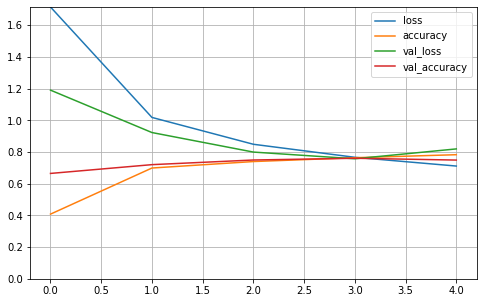

In [39]:
res_net.plot_progress()

---
### <span style="color:#0b486b"> <div  style="text-align:center">**THE END**</div> </span>